In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# charger le fichier log_export.parquet
import pandas as pd

# Charger le fichier .parquet
df = pd.read_parquet('log_export.parquet')

# Afficher les premières lignes pour vérifier le chargement
print(df.head())


                  date           ipsrc          ipdst proto  portsrc  portdst  \
0  2024-03-20 01:29:24    94.102.61.47  159.84.146.99   TCP  52502.0   3178.0   
1  2024-03-20 01:29:25  176.111.174.85  159.84.146.99   TCP  48739.0   2231.0   
2  2024-03-20 01:29:27   66.249.65.106  159.84.146.99   TCP  50501.0    443.0   
3  2024-03-20 01:29:34   89.248.163.75  159.84.146.99   TCP  43312.0   8845.0   
4  2024-03-20 01:29:38   42.58.163.244  159.84.146.99   TCP   9746.0     23.0   

   regle  action interface_in Interface_out  divers  
0  999.0    DENY         eth0          None     6.0  
1  999.0    DENY         eth0          None     6.0  
2    1.0  PERMIT         eth0          None     6.0  
3  999.0    DENY         eth0          None     6.0  
4    7.0    DENY         eth0          None     6.0  


In [3]:
df

,date,ipsrc,ipdst,proto,portsrc,portdst,regle,action,interface_in,Interface_out,divers
0,2024-03-20 01:29:24,94.102.61.47,159.84.146.99,TCP,52502.0,3178.0,999.0,DENY,eth0,None,6.0
1,2024-03-20 01:29:25,176.111.174.85,159.84.146.99,TCP,48739.0,2231.0,999.0,DENY,eth0,None,6.0
2,2024-03-20 01:29:27,66.249.65.106,159.84.146.99,TCP,50501.0,443.0,1.0,PERMIT,eth0,None,6.0
3,2024-03-20 01:29:34,89.248.163.75,159.84.146.99,TCP,43312.0,8845.0,999.0,DENY,eth0,None,6.0
4,2024-03-20 01:29:38,42.58.163.244,159.84.146.99,TCP,9746.0,23.0,7.0,DENY,eth0,None,6.0
...,...,...,...,...,...,...,...,...,...,...,...
11997647,2025-02-12 10:08:30,23.22.35.162,159.84.146.99,TCP,12680.0,443.0,1.0,PERMIT,eth0,None,6.0
11997648,2025-02-12 10:08:33,114.45.140.91,159.84.146.99,TCP,42640.0,443.0,1.0,PERMIT,eth0,None,6.0
11997649,2025-02-12 10:08:34,3.224.220.101,159.84.146.99,TCP,24581.0,443.0,1.0,PERMIT,eth0,None,6.0
11997650,2025-02-12 10:08:36,192.44.68.176,159.84.146.99,TCP,13575.0,443.0,1.0,PERMIT,eth0,None,6.0


In [4]:
df = df.drop(columns=['Interface_out', 'interface_in', 'divers'])  

In [5]:
df = df.dropna()

In [6]:
df

,date,ipsrc,ipdst,proto,portsrc,portdst,regle,action
0,2024-03-20 01:29:24,94.102.61.47,159.84.146.99,TCP,52502.0,3178.0,999.0,DENY
1,2024-03-20 01:29:25,176.111.174.85,159.84.146.99,TCP,48739.0,2231.0,999.0,DENY
2,2024-03-20 01:29:27,66.249.65.106,159.84.146.99,TCP,50501.0,443.0,1.0,PERMIT
3,2024-03-20 01:29:34,89.248.163.75,159.84.146.99,TCP,43312.0,8845.0,999.0,DENY
4,2024-03-20 01:29:38,42.58.163.244,159.84.146.99,TCP,9746.0,23.0,7.0,DENY
...,...,...,...,...,...,...,...,...
11997647,2025-02-12 10:08:30,23.22.35.162,159.84.146.99,TCP,12680.0,443.0,1.0,PERMIT
11997648,2025-02-12 10:08:33,114.45.140.91,159.84.146.99,TCP,42640.0,443.0,1.0,PERMIT
11997649,2025-02-12 10:08:34,3.224.220.101,159.84.146.99,TCP,24581.0,443.0,1.0,PERMIT
11997650,2025-02-12 10:08:36,192.44.68.176,159.84.146.99,TCP,13575.0,443.0,1.0,PERMIT


In [7]:
import ipaddress

# Conversion des adresses IP en entiers
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0

df['ipsrc'] = df['ipsrc'].apply(ip_to_int)
df['ipdst'] = df['ipdst'].apply(ip_to_int)

# Définir la variable cible : si l'action est DENY plusieurs fois, l'IP est suspecte
df['action'] = df['action'].apply(lambda x: 1 if x == 'DENY' else 0)

# Encodage des variables catégorielles avec One-Hot Encoding
df = pd.get_dummies(df, columns=['proto'], drop_first=True)

In [8]:
df['date']

0           2024-03-20 01:29:24
1           2024-03-20 01:29:25
2           2024-03-20 01:29:27
3           2024-03-20 01:29:34
4           2024-03-20 01:29:38
                   ...         
11997647    2025-02-12 10:08:30
11997648    2025-02-12 10:08:33
11997649    2025-02-12 10:08:34
11997650    2025-02-12 10:08:36
11997651    2025-02-12 10:08:39
Name: date, Length: 11997644, dtype: object

In [9]:
# Supposons que 'X_train' contienne une colonne avec des dates sous forme de chaîne
df['date'] = pd.to_datetime(df['date'])

In [10]:
df['date']

0          2024-03-20 01:29:24
1          2024-03-20 01:29:25
2          2024-03-20 01:29:27
3          2024-03-20 01:29:34
4          2024-03-20 01:29:38
                   ...        
11997647   2025-02-12 10:08:30
11997648   2025-02-12 10:08:33
11997649   2025-02-12 10:08:34
11997650   2025-02-12 10:08:36
11997651   2025-02-12 10:08:39
Name: date, Length: 11997644, dtype: datetime64[ns]

In [11]:
df

,date,ipsrc,ipdst,portsrc,portdst,regle,action
0,2024-03-20 01:29:24,1583758639,2673119843,52502.0,3178.0,999.0,1
1,2024-03-20 01:29:25,2960109141,2673119843,48739.0,2231.0,999.0,1
2,2024-03-20 01:29:27,1123631466,2673119843,50501.0,443.0,1.0,0
3,2024-03-20 01:29:34,1509466955,2673119843,43312.0,8845.0,999.0,1
4,2024-03-20 01:29:38,708486132,2673119843,9746.0,23.0,7.0,1
...,...,...,...,...,...,...,...
11997647,2025-02-12 10:08:30,387326882,2673119843,12680.0,443.0,1.0,0
11997648,2025-02-12 10:08:33,1915587675,2673119843,42640.0,443.0,1.0,0
11997649,2025-02-12 10:08:34,65068133,2673119843,24581.0,443.0,1.0,0
11997650,2025-02-12 10:08:36,3224126640,2673119843,13575.0,443.0,1.0,0


In [12]:
# Vérification des valeurs manquantes par colonne
missing_values = df.isnull().sum()
print(missing_values)

date       0
ipsrc      0
ipdst      0
portsrc    0
portdst    0
regle      0
action     0
dtype: int64


In [13]:
df['action']

0           1
1           1
2           0
3           1
4           1
           ..
11997647    0
11997648    0
11997649    0
11997650    0
11997651    0
Name: action, Length: 11997644, dtype: int64

In [14]:
# Sélection des features (X) et de la cible (y)
X = df.drop(columns=['action', 'date'])  # Garder les colonnes pertinentes
y = df['action']  # Nouvelle colonne cible

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11997644 entries, 0 to 11997651
Data columns (total 7 columns):
 #   Column   Dtype         
---  ------   -----         
 0   date     datetime64[ns]
 1   ipsrc    int64         
 2   ipdst    int64         
 3   portsrc  float64       
 4   portdst  float64       
 5   regle    float64       
 6   action   int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 732.3 MB


In [16]:
# Modèle Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
y_pred_rf = rf_model.predict(X_test)
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1955462
           1       1.00      1.00      1.00    444067

    accuracy                           1.00   2399529
   macro avg       1.00      1.00      1.00   2399529
weighted avg       1.00      1.00      1.00   2399529



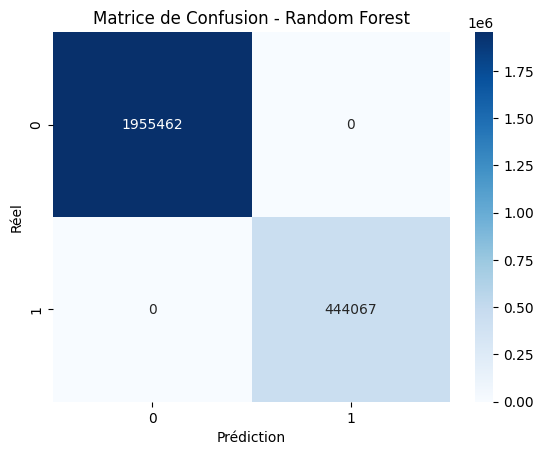

In [18]:
# Visualisation : Carte thermique
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de Confusion - Random Forest')
plt.show()

C:\Users\akaramoko\AppData\Local\Temp\ipykernel_5224\3338336482.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ip_activity.values, y=ip_activity.index, palette='Reds')


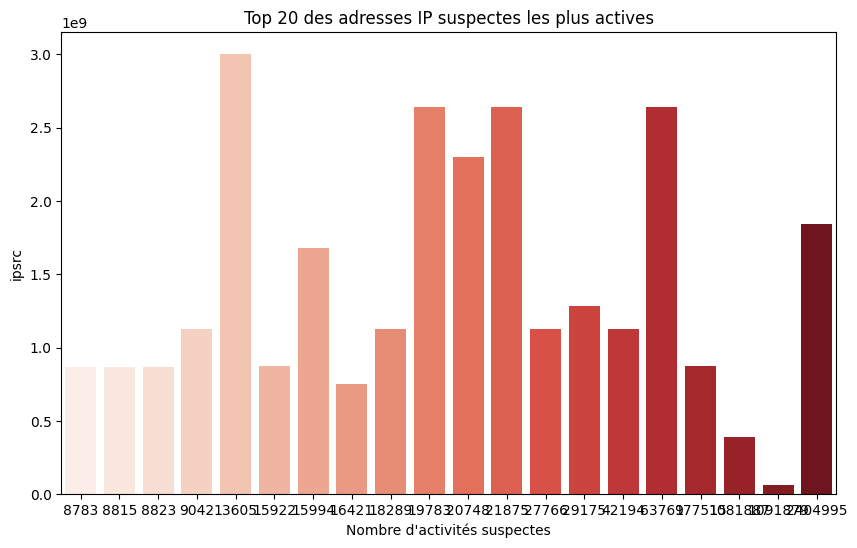

In [19]:
# Liste dynamique des adresses IP suspectes les plus actives
ip_activity = df[df['action'] == 0]['ipsrc'].value_counts().head(20)
plt.figure(figsize=(10,6))
sns.barplot(x=ip_activity.values, y=ip_activity.index, palette='Reds')
plt.xlabel('Nombre d\'activités suspectes')
plt.title('Top 20 des adresses IP suspectes les plus actives')
plt.show()